<a href="https://colab.research.google.com/github/Aafreen2603/Emotion-Classification/blob/main/Emotion_AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DETECT EMOTION FROM FACE

**Based on the human face, detect people's emotion, age, gender, etc.**


Done using 2 Neural networks where,

*   First model will use CNN and Residual blocks to predict facial key points (eye, nose, etc) and their coordinates(xi,yi)

*   Second model will classify the emotions

**MODEL1:**

inputs = 96x96 grayscale images

output = x and y coordinates of 15 key-points

greyscale Image input (96x96) -> AI model -> detect facial key points




---


### Step 1: importing datasets, libraries for 1st model


In [56]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

# drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
%cd /content/drive/My Drive/Project datasets/Emotion+AI+Dataset/Emotion AI Dataset

/content/drive/My Drive/Project datasets/Emotion+AI+Dataset/Emotion AI Dataset


In [58]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

## Facial Key Points Data

2140 rows, 31 columns

for 15 facial key pts-> x, y coordinates => 30 columns

plus 1 column containing the values of pixels for the image (0(black) to 255(white)) => 31 columns


In [59]:
# load data
keyfacial_df = pd.read_csv('/content/drive/My Drive/Project datasets/Emotion+AI+Dataset/Emotion AI Dataset/data.csv')
keyfacial_df

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
2135          67.180378          35.816373           33.239956   
2136          65.724490          36.301020           25.377551   
2137          68.430866          38.651975           28.895857   
2138          64.152180          30.691592           27.000898   
2139          66.683755          34.483429           30.784490   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448715                58.856170                35.274349   
2              34.909642                59.412000                36.320968   
3              37.261774                60.003339                39.127179   
4              38.042032                58.565890                39.621261   
...                  ...                      ...                      ...   
2135           34.921932                59.347973                37.000904   
2136           37.311224                58.530612                37.739796   
2137           37.617027                61.659350                40.100902   
2138           40.868082                56.505624                34.126963   
2139           38.578939                59.255347                36.065143   

      left_eye_outer_corner_x  left_eye_outer_corner_y  \
0                   73.130346                39.969997   
1                   70.722723                36.187166   
2                   70.984421                36.320968   
3                   72.314713                38.380967   
4                   72.515926                39.884466   
...                       ...                      ...   
2135                72.667896                37.097600   
2136                74.448980                37.525510   
2137                75.586792                40.219182   
2138                73.436776                28.556335   
2139                73.942694                34.624653   

      right_eye_inner_corner_x  right_eye_inner_corner_y  ...  nose_tip_y  \
0                    36.356571                 37.389402  ...   57.066803   
1                    36.034723                 34.361532  ...   55.660936   
2                    37.678105                 36.320968  ...   53.538947   
3                    37.618643                 38.754115  ...   54.166539   
4                    36.982380                 39.094852  ...   64.889521   
...                        ...                       ...  ...         ...   
2135                 39.404349                 36.589944  ...   60.065396   
2136                 33.551020                 38.107143  ...   62.472789   
2137                 37.665118                 39.087245  ...   63.289576   
2138                 34.746122                 40.506939  ...   59.735799   
2139                 37.478531                 39.398041  ...   59.269388   

      mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
0               61.195308            79.970165             28.614496   
1               56.421447            76.352000             35.122383   
2               60.822947            73.014316             33.726316   
3               65.598887            72.703722             37.245496   
4               60.671411            77.523239             31.191755   
...                   ...                  ...                   ...   
2135            64.397610            73.248393             35.446431   
2136            66.928121            79.229046             28.015377   
2137  

### Data Exploration:

In [60]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [61]:
keyfacial_df.isnull().sum() # Check if null values exist in the dataframe

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [62]:
keyfacial_df['Image'].shape

(2140,)

In [63]:
# RESHAPE the Image data into 96x96
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# convert this into numpy array using np.fromstring
# convert obtained 1D array into 2D array of shape (96, 96)

keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x,dtype=int,sep=' ').reshape(96, 96))

In [64]:
# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

In [65]:
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

In [66]:
# Image Vizualization with facial keypoints
def plot_the_image(k):
  plt.imshow(keyfacial_df['Image'][k], cmap = 'gray')
  for j in range(1, 31, 2): # for each datapoint(0 to 31, with a step of 2) plot (x,y) on the image in red
          plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx') # j-1 because j has a step of 2

<ipython-input-66-df2501d505df>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx') # j-1 because j has a step of 2


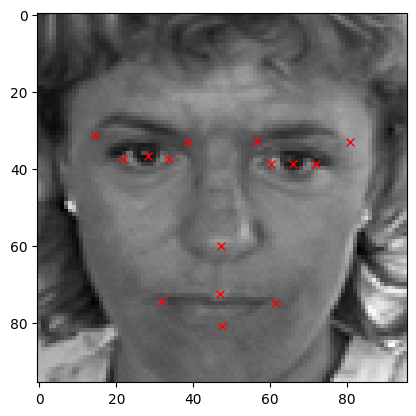

In [67]:
# display a random image
i = np.random.randint(1, len(keyfacial_df)) # select a random no. b/w 1 and length of df
plot_the_image(i)

<ipython-input-66-df2501d505df>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx') # j-1 because j has a step of 2


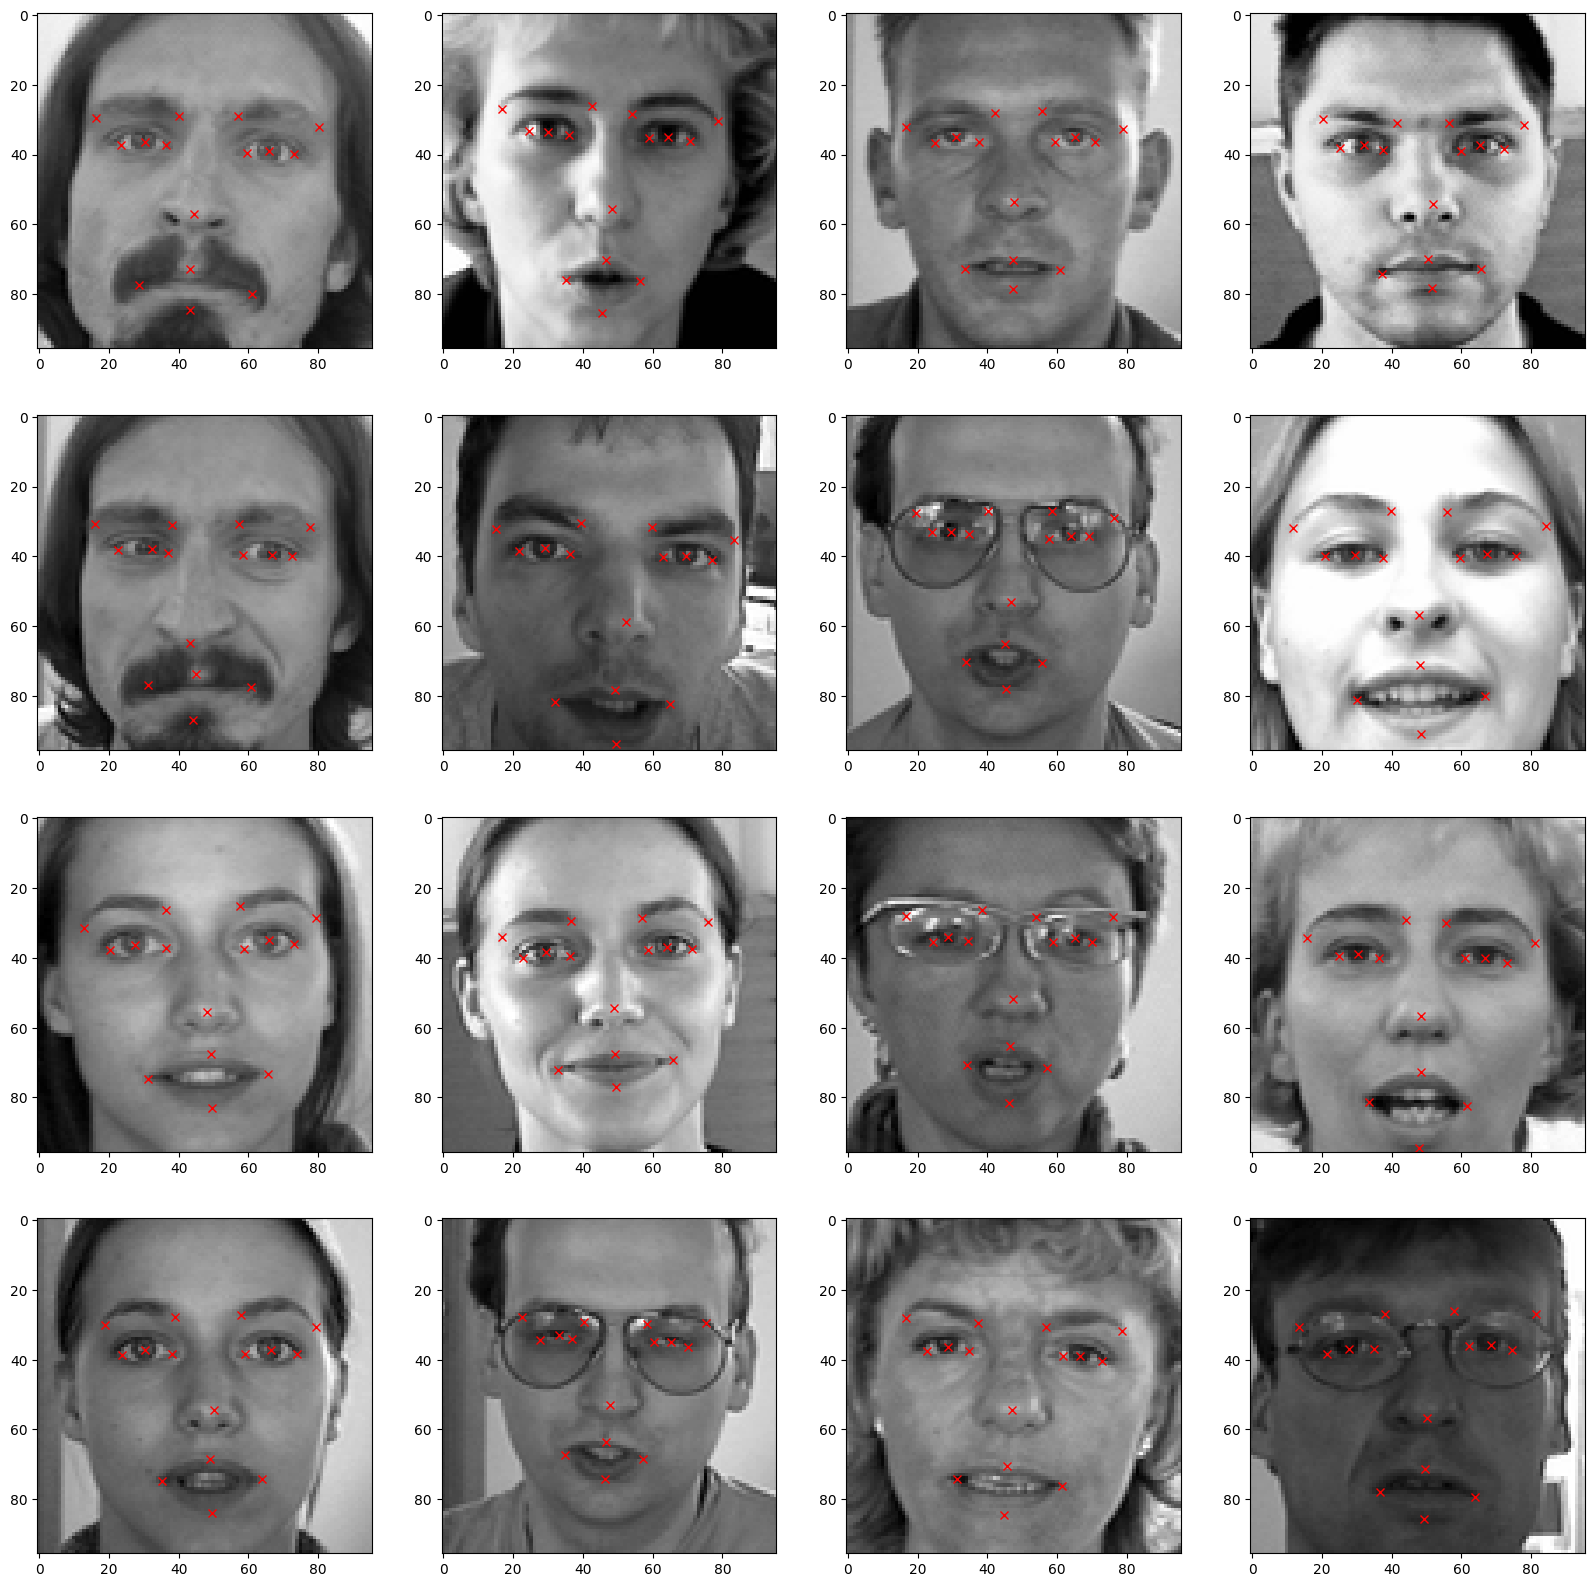

In [68]:
# Viewing images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16): # print out 16 images
    ax = fig.add_subplot(4, 4, i+1) # creates a grid of 16 imgs, 4 rows and 4 cols
    plot_the_image(i)

<ipython-input-66-df2501d505df>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx') # j-1 because j has a step of 2


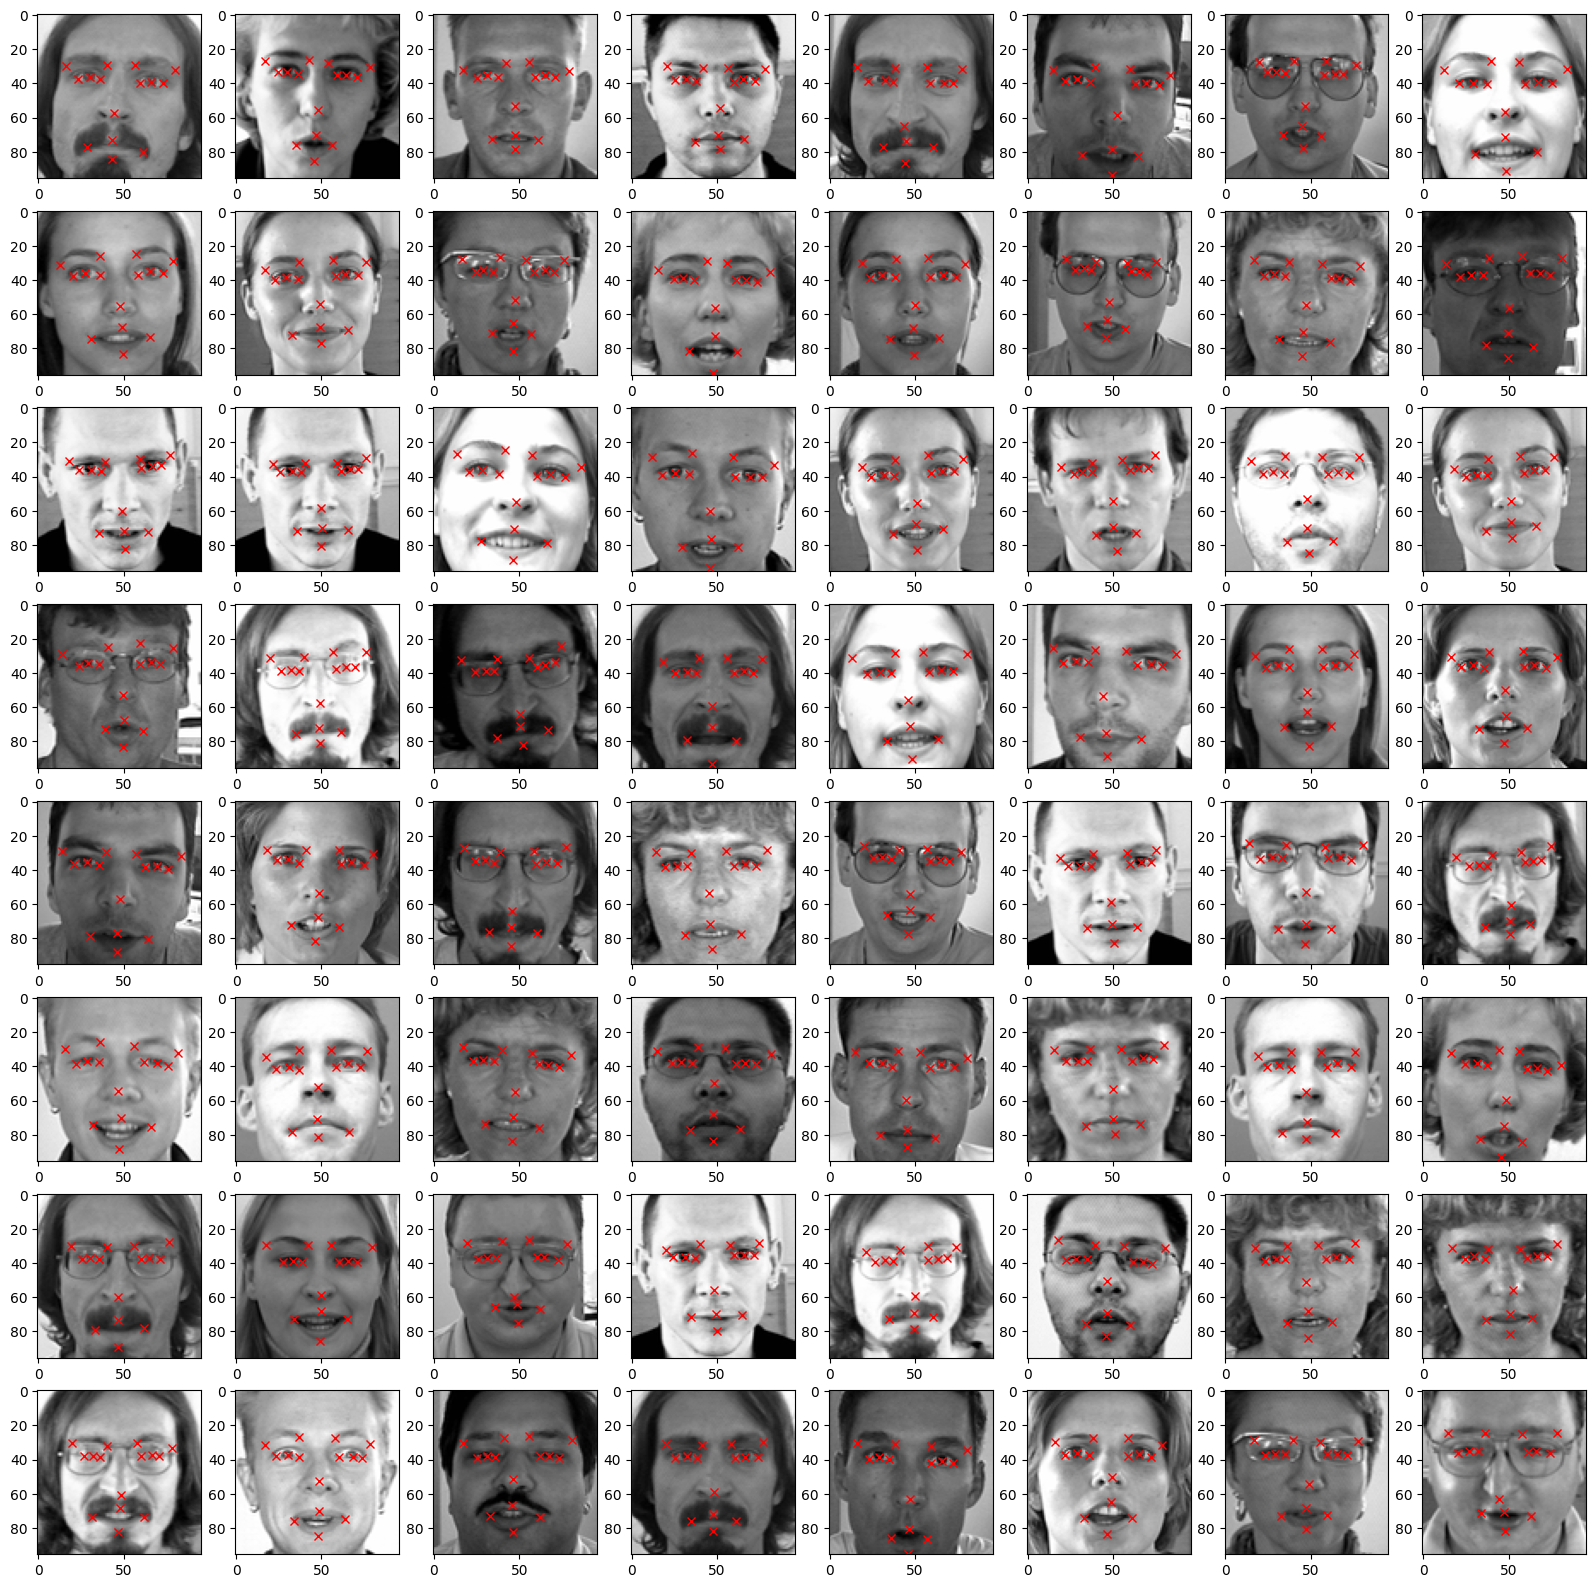

In [69]:
import random

fig = plt.figure(figsize=(20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)
    plot_the_image(i)

## Image Augmentation

Flip the images (vertically, horizontally), increase the brightness, darken it, zoom in

**This improves the generalization capability of the model.**

In [70]:
# Create a new copy of the df
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [71]:
columns = keyfacial_df_copy.columns[:-1] # all except last col
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [72]:
# Horizontal Flip - flip along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# => y coordinate values would be the same, only x coordiante values would change
# => subtract our initial x-coordinate values from width of the image (96)
for i in range(len(columns)): # for each column, we need only x coordinate values (ones with index 0,2,4...)
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96.-float(x) ) # replace x with -x

<ipython-input-66-df2501d505df>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx') # j-1 because j has a step of 2


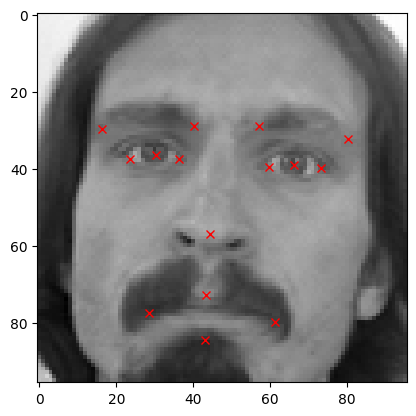

In [73]:
# Show the Original image
plot_the_image(0)

<ipython-input-74-fe6d77f074d9>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


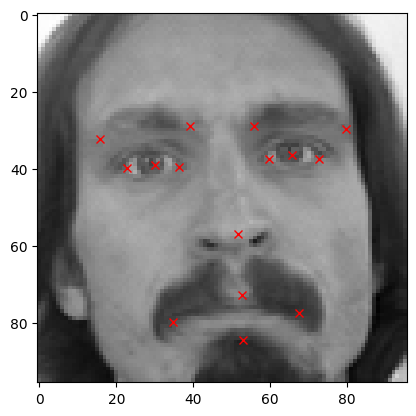

In [74]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [75]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))
augmented_df.shape

(4280, 31)

In [76]:
# Randomingly increasing the brightness of the images
# to increase the brightness of the image -> multiply pixel values by random values between 1.5 & 2; and clip the value to stay b/w 0 & 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5,2)*x, 0.0,255.0)) # random values between 1.5,2 & clip the value to stay b/w 0 & 255

augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

<ipython-input-77-65d450fa1f70>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


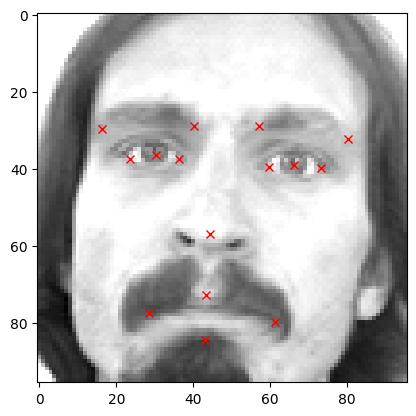

In [77]:
# Show Image with increased brightness
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [78]:
# Flip along x axis: (y->(-y))
keyfacial_df_copy = copy.copy(keyfacial_df)

In [79]:
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis=0)) # axis=0 for vertical flip

for i in range(len(columns)): # columns 1,3,5...
  if i%2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. -float(x)) # 96 pixels => 96-x

<ipython-input-80-616847b82f0f>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


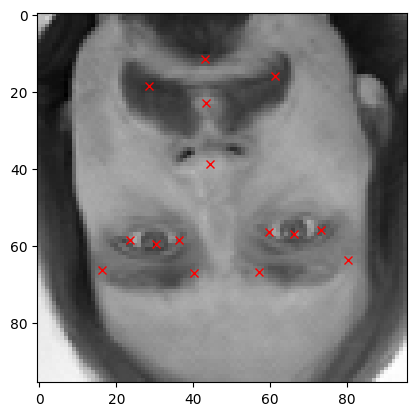

In [80]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

## Data Normalization and Training Data Preparation

pixel values: 0 to 255 -> get them between 0 to 1 using normalization for input to our neural network


In [81]:
img = augmented_df[:,30] # all images in 31st column

img = img/255. # Normalize the images

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))     # one array with all the images


# convert to batch format
# Iterate through the img list and add image values to X after expanding it's dimension from (96,96) to (96,96,1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis=2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [82]:
# y = target = values of x & y coordinates
y = augmented_df[:,:30] # all columns except last column
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [83]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [84]:
print(X_train.shape)
print(X_test.shape)

(5136, 96, 96, 1)
(1284, 96, 96, 1)


## Build a Deep Residual Neural Network for key facial points detection

In [96]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense


In [97]:
# This residual block has three parts:
#     a convolutional block (with dimension changes),
#     two identity blocks (without dimension changes), and
#     skip connections (shortcut connections) for adding the input back to the output.

# The use of convolutions, batch normalization, & ReLU activation in the block
# helps the model learn better and faster by preserving gradient flow during backpropagation

def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  # Unpack filter tuple into 3 variables: f1, f2, and f3, which represent the number of filters for three convolutional layers in the residual block
  f1 , f2, f3 = filter

  # Main path
  # conv layer 1: 1x1 conv, f1 filters
  # glorot_uniform initializer(AKA Xavier initialization) used to initialize the weights
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X) # downsamples the input =>  reduces the spatial dimensions of the feature map
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_a')(X) # normalizes the output of the previous layer
  X = Activation('relu')(X) # introduces non-linearity => helps learn more complex relationships

  # conv layer 2: 3x3 conv, f2 filters
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  # conv layer 3: 1x1 conv, f3 filters
  X = Conv2D(f3, kernel_size=(1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)


  # Identity Block 1
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis=3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)


  # Identity Block 2
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [101]:
# Input tensor
input_shape = (96, 96, 1)
X_input = Input(input_shape)
X = ZeroPadding2D((3,3))(X_input)

# stage 1
X = Conv2D(64,(7,7),strides=(2,2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides=(2,2))(X)

# stage 2 (for naming purpose only)
# filter -> 3 conv layers the block have 64,64,256 filters respectively
X = res_block(X, filter= [64,64,256], stage=2)

# stage 3
X = res_block(X, filter= [128,128,512], stage=3)

# X = res_block(X, filter= [256,256,1024], stage=4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X) # 3D tensor into 1D vector
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation='linear')(X)


In [102]:
model_1_facialKeyPoints = Model(inputs=X_input, outputs=X)
model_1_facialKeyPoints.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 96, 96, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 102, 102, 1)    │              0 │ input_layer_6[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 23, 23, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_27[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_97[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_98             │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_copy (Conv2D)  │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_c (Conv2D)

 Total params: 18,016,286 (68.73 MB)

 Trainable params: 18,007,710 (68.69 MB)

 Non-trainable params: 8,576 (33.50 KB)

## Training

In [110]:
import tensorflow as tf
adam_opti = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer=adam_opti, metrics=['accuracy'])

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="FacialKeyPoints_weights.keras", verbose=1, save_best_only=True)


In [111]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 2, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5403 - loss: 587.0178
Epoch 1: val_loss improved from inf to 901.13898, saving model to FacialKeyPoints_weights.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.5407 - loss: 584.9136 - val_accuracy: 0.6498 - val_loss: 901.1390
Epoch 2/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6043 - loss: 113.2565
Epoch 2: val_loss improved from 901.13898 to 435.02182, saving model to FacialKeyPoints_weights.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.6043 - loss: 113.1974 - val_accuracy: 0.6265 - val_loss: 435.0218


In [122]:
# Save model architecture to JSON
model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json", "w") as json_file:
    json_file.write(model_json)

## Access Performance

In [124]:
with open('FacialKeyPoints-model.json', 'r') as json_file:
    json_savedModel = json_file.read()

# load the model architecture
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.keras')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [125]:
# Evaluate the model
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.6778 - loss: 451.6568
Accuracy : 0.6534267663955688


In [ ]:
# epochs=2 -> accuracy: 0.6778 - loss: 451.6568

In [127]:
history.history.keys() # Get the model keys

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

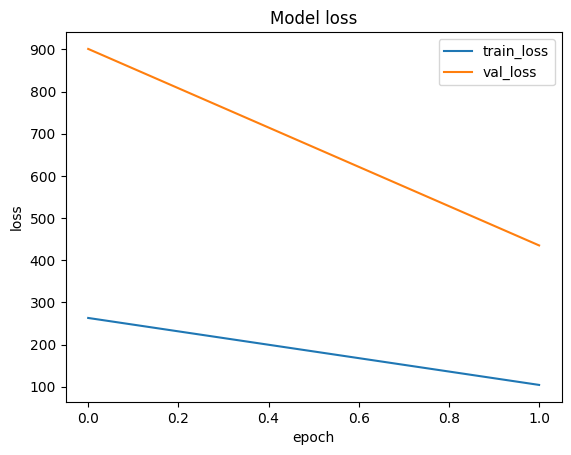

In [128]:
# Visualize the training artifacts
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# Model 2: Facial Expression Detection

In [129]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')
facialexpression_df

emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]

In [131]:
facialexpression_df[' pixels'][0] # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [132]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [133]:
# Resize images from (48, 48) to (96, 96)

def resize(x):

  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [134]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [135]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [136]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [137]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [138]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

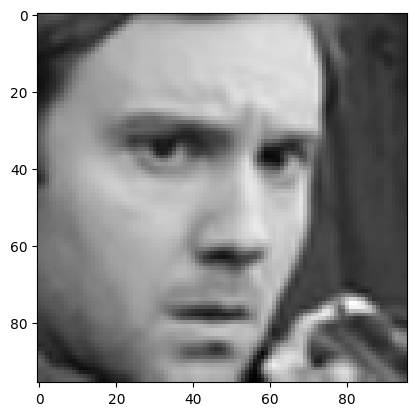

In [139]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

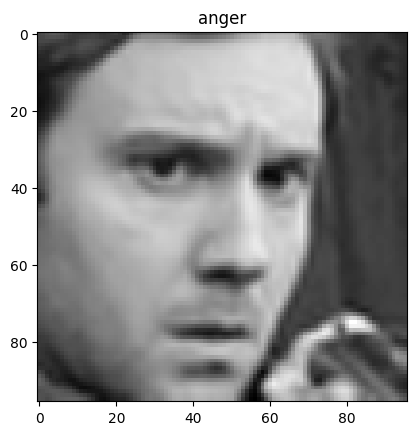

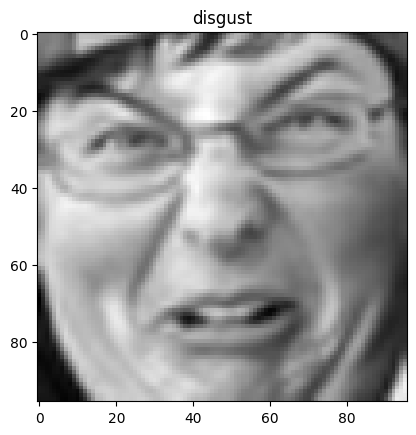

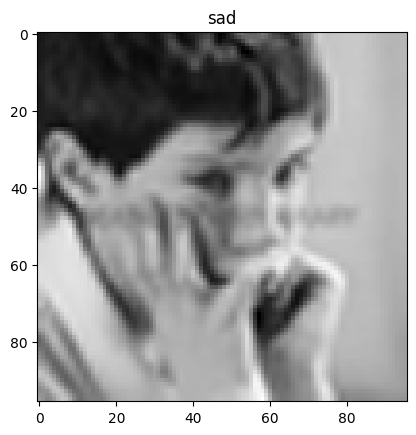

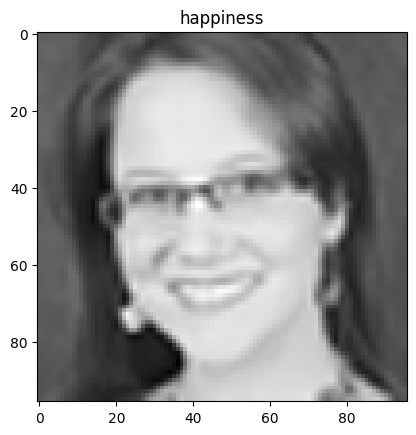

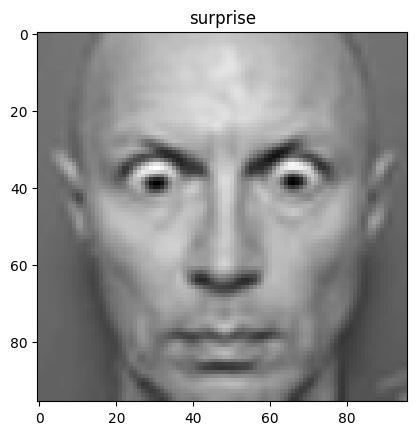

In [140]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [141]:
facialexpression_df.emotion.value_counts().index

Index([3, 2, 0, 4, 1], dtype='int64', name='emotion')

In [142]:
facialexpression_df.emotion.value_counts()

emotion
3    8989
2    6077
0    4953
4    4002
1     547
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

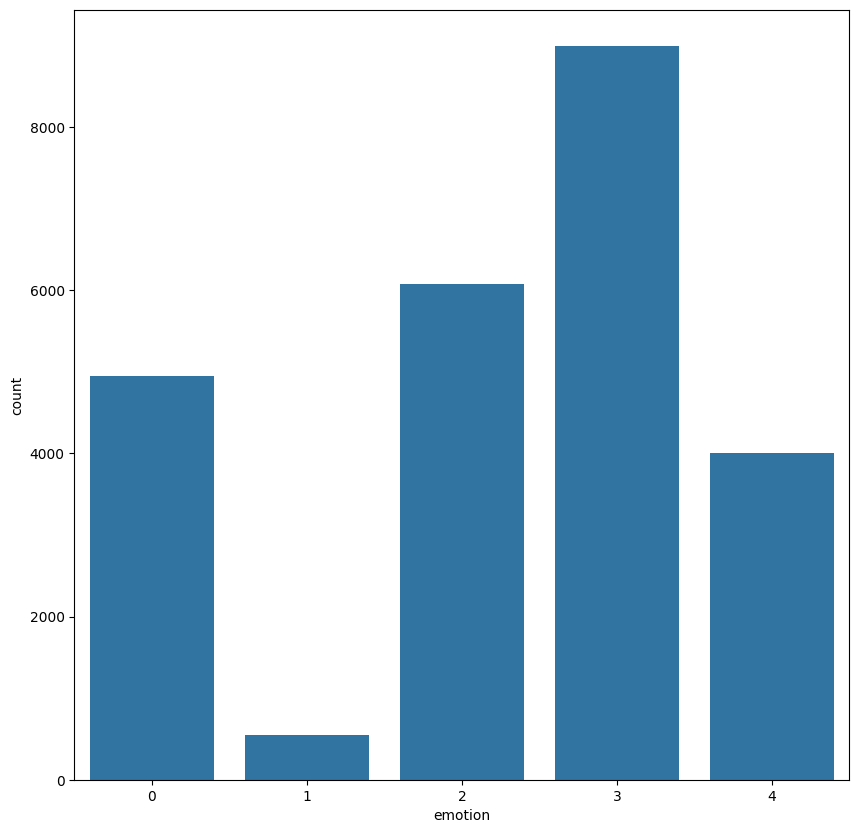

In [143]:
plt.figure(figsize = (10,10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

In [144]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

In [145]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [146]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [147]:
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [153]:
# split the dataframe in to train, test and validation data frames
from sklearn.model_selection import train_test_split
X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

print(X_val.shape, y_val.shape)
print(X_Test.shape, y_Test.shape)
print(X_train.shape, y_train.shape)

(1228, 96, 96, 1) (1228, 5)
(1229, 96, 96, 1) (1229, 5)
(22111, 96, 96, 1) (22111, 5)


In [154]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [155]:
X_train

array([[[[ 0.5754006 ],
         [ 0.5744825 ],
         [ 0.5730574 ],
         ...,
         [ 0.7860283 ],
         [ 0.7813674 ],
         [ 0.77839607]],

        [[ 0.5671594 ],
         [ 0.5659415 ],
         [ 0.5640531 ],
         ...,
         [ 0.81564635],
         [ 0.8096593 ],
         [ 0.8058642 ]],

        [[ 0.553386  ],
         [ 0.55168855],
         [ 0.54906034],
         ...,
         [ 0.86461776],
         [ 0.8564164 ],
         [ 0.8512467 ]],

        ...,

        [[ 0.9430095 ],
         [ 0.9431635 ],
         [ 0.94326156],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 1.        ]],

        [[ 0.9844863 ],
         [ 0.98437905],
         [ 0.9841524 ],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 1.        ]],

        [[ 1.0117553 ],
         [ 1.0112207 ],
         [ 1.0103449 ],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 1.        ]]],


       [[[ 0.2871134 ],


In [158]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

## Build and Train model for facial expression classification

In [160]:
# Input tensor
input_shape = (96, 96, 1)
X_input = Input(input_shape)
X = ZeroPadding2D((3, 3))(X_input)

# stage 1
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# stage 2
X = res_block(X, filter= [64, 64, 256], stage= 2)

# stage 3
X = res_block(X, filter= [128, 128, 512], stage= 3)

# stage 4
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')
model_2_emotion.summary()

Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 96, 96, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 102, 102, 1)    │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_134            │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_36          │ (None, 23, 23, 64)     │              0 │ activation_134[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_37          │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_37[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_135            │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_135[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_136            │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_copy (Conv2D)  │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_c (Conv2D)

 Total params: 1,174,021 (4.48 MB)

 Trainable params: 1,165,445 (4.45 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [161]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [164]:
# first facial key points model was saved here-> FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="FacialExpression_weights.keras", verbose=1, save_best_only=True)
# .keras extension instead of .hdf5

In [165]:
history = model_2_emotion.fit(
		 train_datagen.flow(X_train, y_train, batch_size=64),
		 validation_data=(X_val, y_val),
		 steps_per_epoch = len(X_train) // 64,
		 epochs= 2,
		 callbacks=[checkpointer, earlystopping]
		 )

Epoch 1/2
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4489 - loss: 1.3137
Epoch 1: val_loss improved from inf to 1.53519, saving model to FacialExpression_weights.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - accuracy: 0.4491 - loss: 1.3133 - val_accuracy: 0.4080 - val_loss: 1.5352
Epoch 2/2
  1/345 ━━━━━━━━━━━━━━━━━━━━ 8:00 1s/step - accuracy: 0.6719 - loss: 0.9680

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.53519
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6719 - loss: 0.9680 - val_accuracy: 0.3958 - val_loss: 1.5544


In [179]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

### Assess Performance

In [180]:
with open('FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('FacialExpression_weights.keras')
model_2_emotion.compile(optimizer="Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [181]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.4112 - loss: 1.5188
Test Accuracy: 0.42636290192604065


In [182]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [183]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

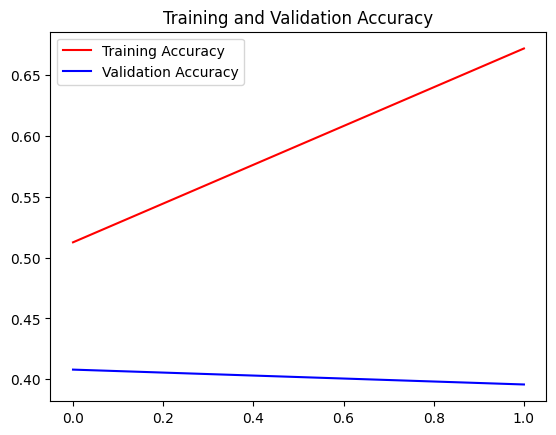

In [187]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

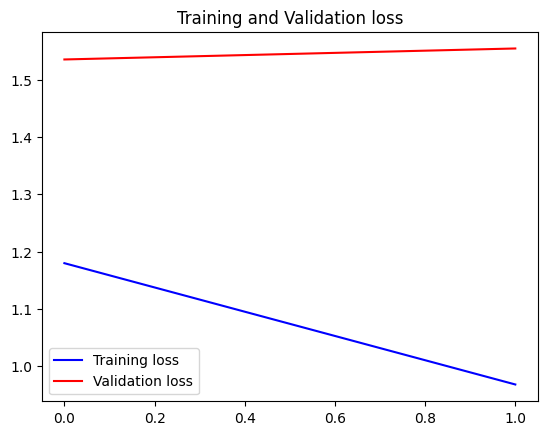

In [188]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [189]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step


In [190]:
y_true.shape

(1229,)

<Axes: >

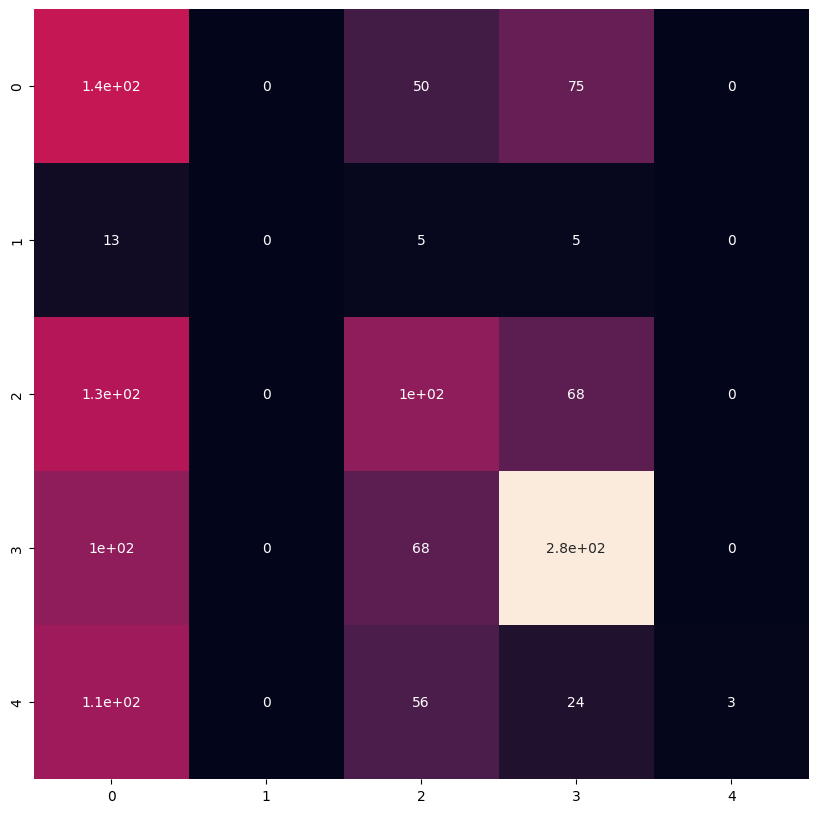

In [191]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

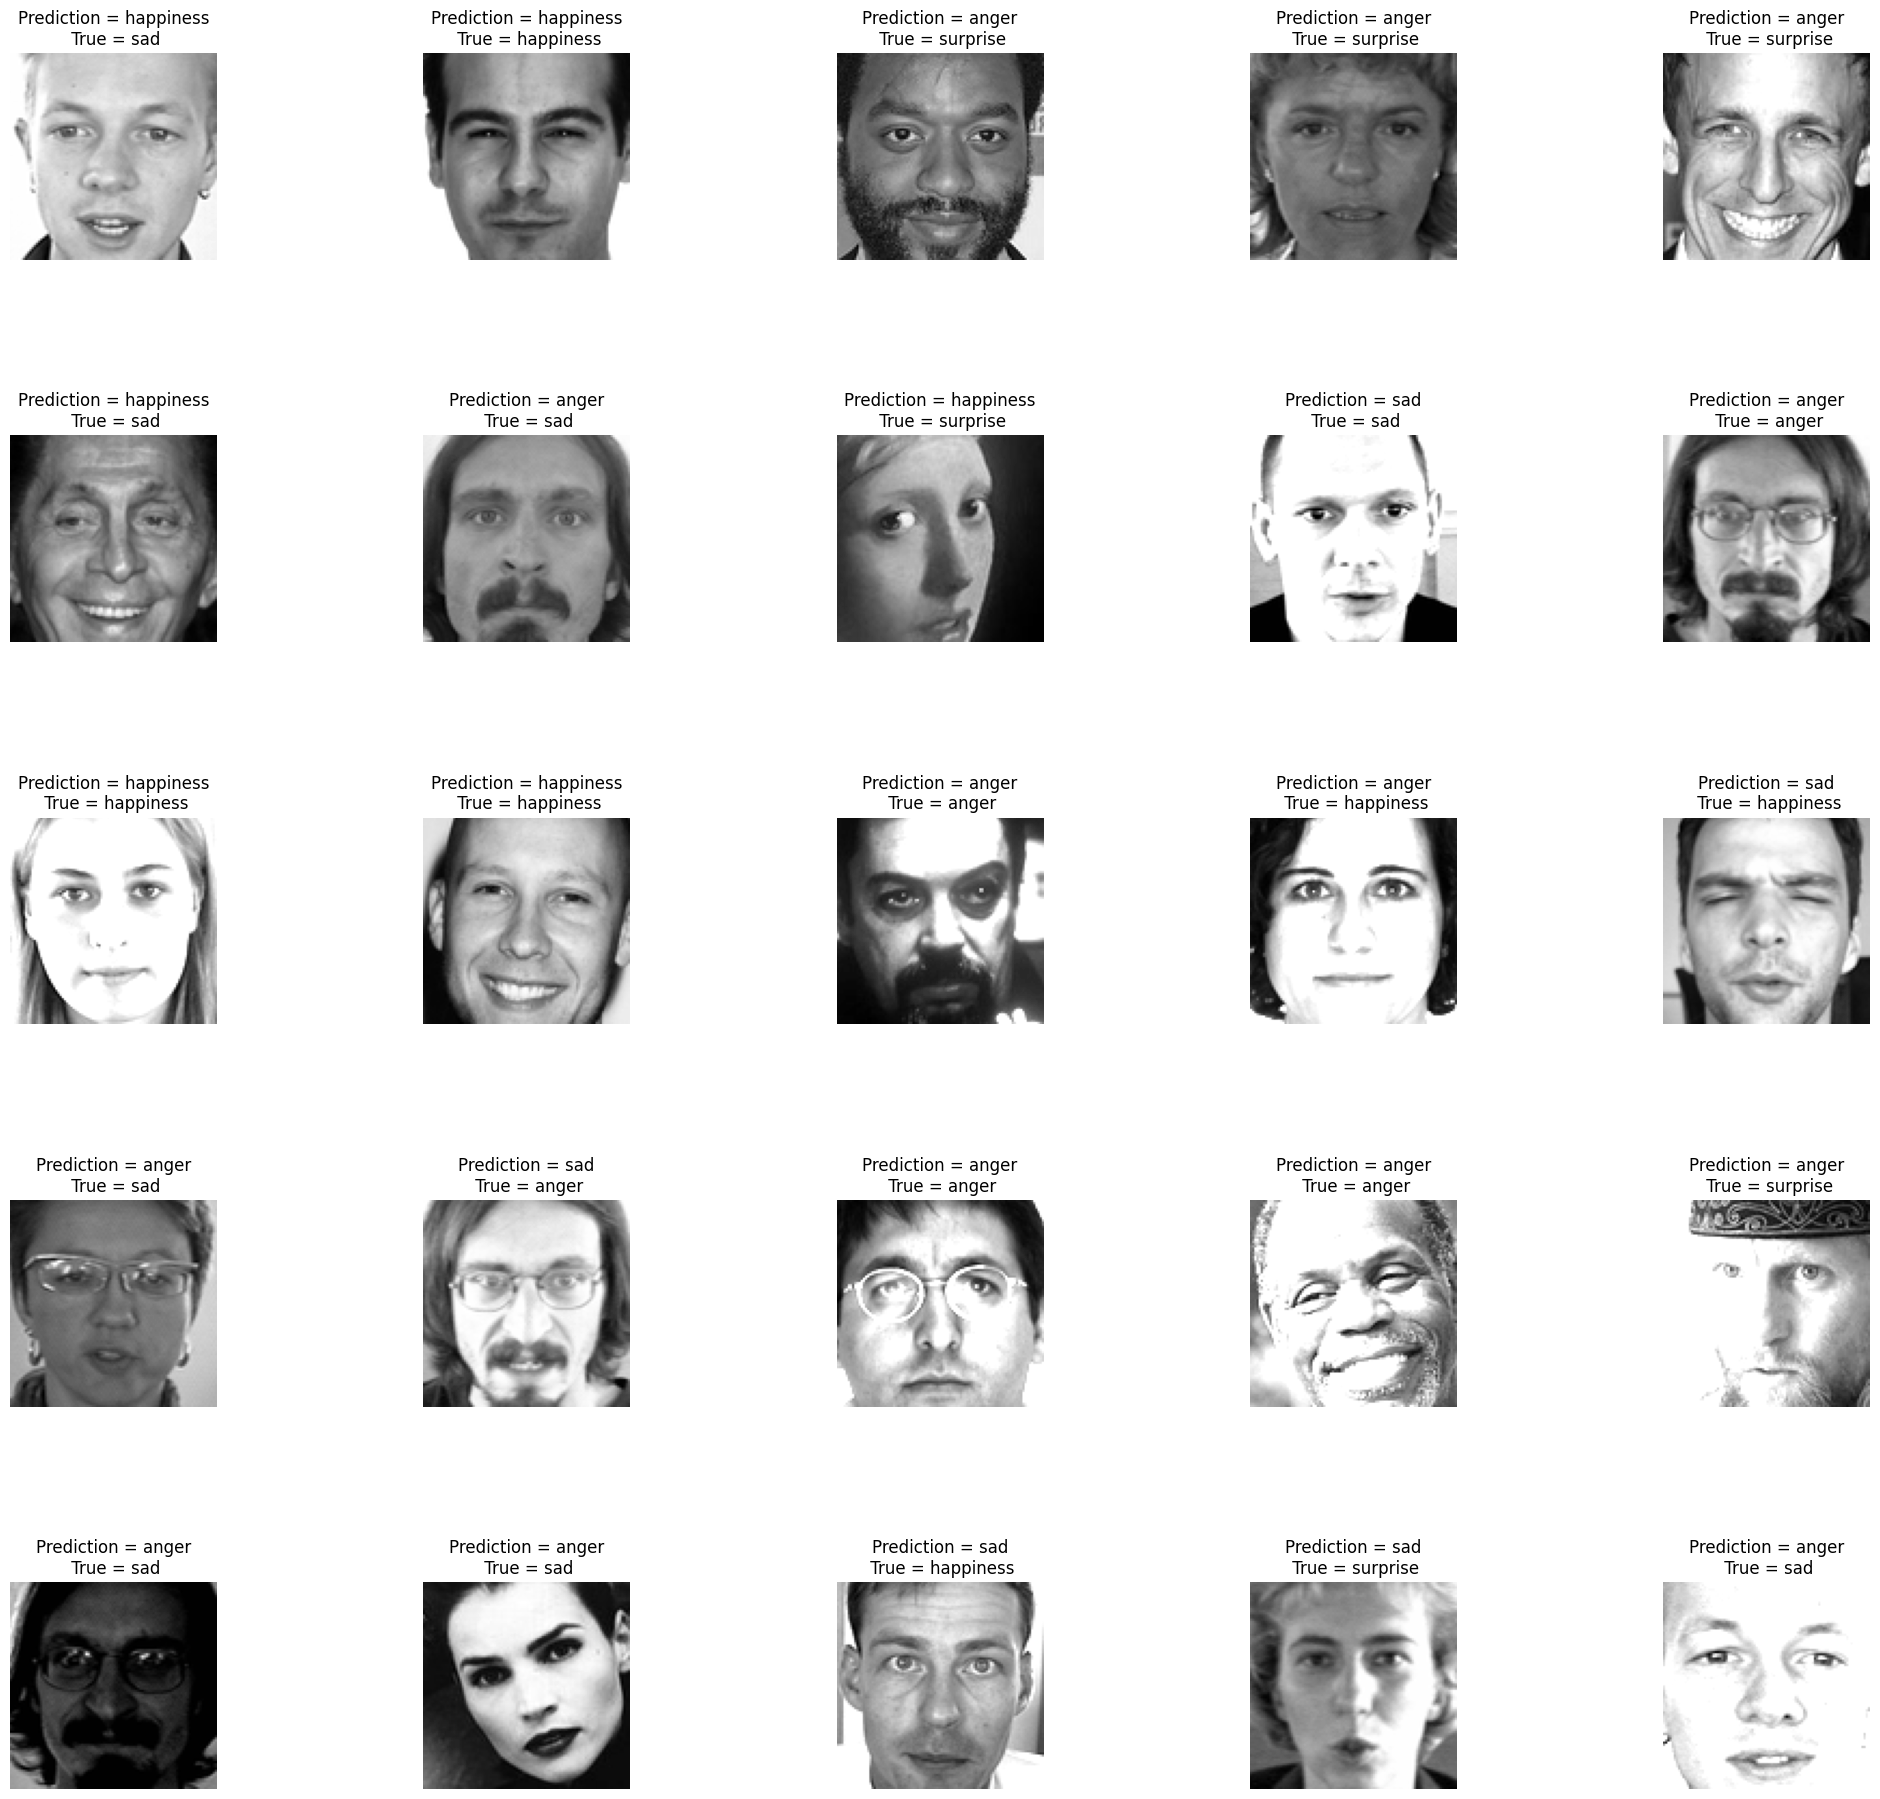

In [192]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [193]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.28      0.52      0.36       261
           1       0.00      0.00      0.00        23
           2       0.36      0.34      0.35       297
           3       0.62      0.62      0.62       453
           4       1.00      0.02      0.03       195

    accuracy                           0.43      1229
   macro avg       0.45      0.30      0.27      1229
weighted avg       0.53      0.43      0.40      1229



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# PART 3. COMBINE BOTH FACIAL EXPRESSION AND KEY POINTS DETECTION MODELS

In [194]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [195]:
df_predict = predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step


In [196]:
df_predict.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          23.711567          30.280155           54.073997   
1          23.476660          30.055946           54.358761   
2          23.136236          30.804131           56.315613   
3          22.889679          30.277700           55.663689   
4          24.243008          30.772430           54.564316   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           30.822104                29.507956                30.581539   
1           30.950752                29.020235                30.704273   
2           31.617641                29.341938                31.254147   
3           31.081024                28.728685                30.835567   
4           31.152351                29.731710                30.929850   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                18.266649                31.521603                 49.297333   
1                17.570566                31.452370                 49.622261   
2                16.990881                32.198414                 51.527420   
3                16.585371                31.763472                 50.906837   
4                18.571627                31.617306                 49.906418   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 30.514158  ...   44.444271            27.417671   
1                 30.224411  ...   44.085407            26.984482   
2                 30.761736  ...   44.975357            26.778215   
3                 30.503428  ...   44.698868            26.542147   
4                 30.748152  ...   44.856792            27.592808   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            61.162739             52.061913             62.818130   
1            60.917942             52.066883             62.349342   
2            62.409321             53.928455             64.035126   
3            61.799244             53.451317             63.294106   
4            61.641537             52.337845             63.284843   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               39.612778               58.789986                  39.978359   
1               39.627995               58.167923                  40.035145   
2               40.693024               59.540428                  41.319485   
3               40.241341               58.712234                  41.018047   
4               39.900078               59.086731                  40.644924   

   mouth_center_bottom_lip_y  emotion  
0                  67.584366        0  
1                  67.521881        3  
2                  69.487213        3  
3                  68.461487        3  
4                  68.289520        3  

[5 rows x 31 columns]

<ipython-input-197-b6b1c6ed8fe0>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')


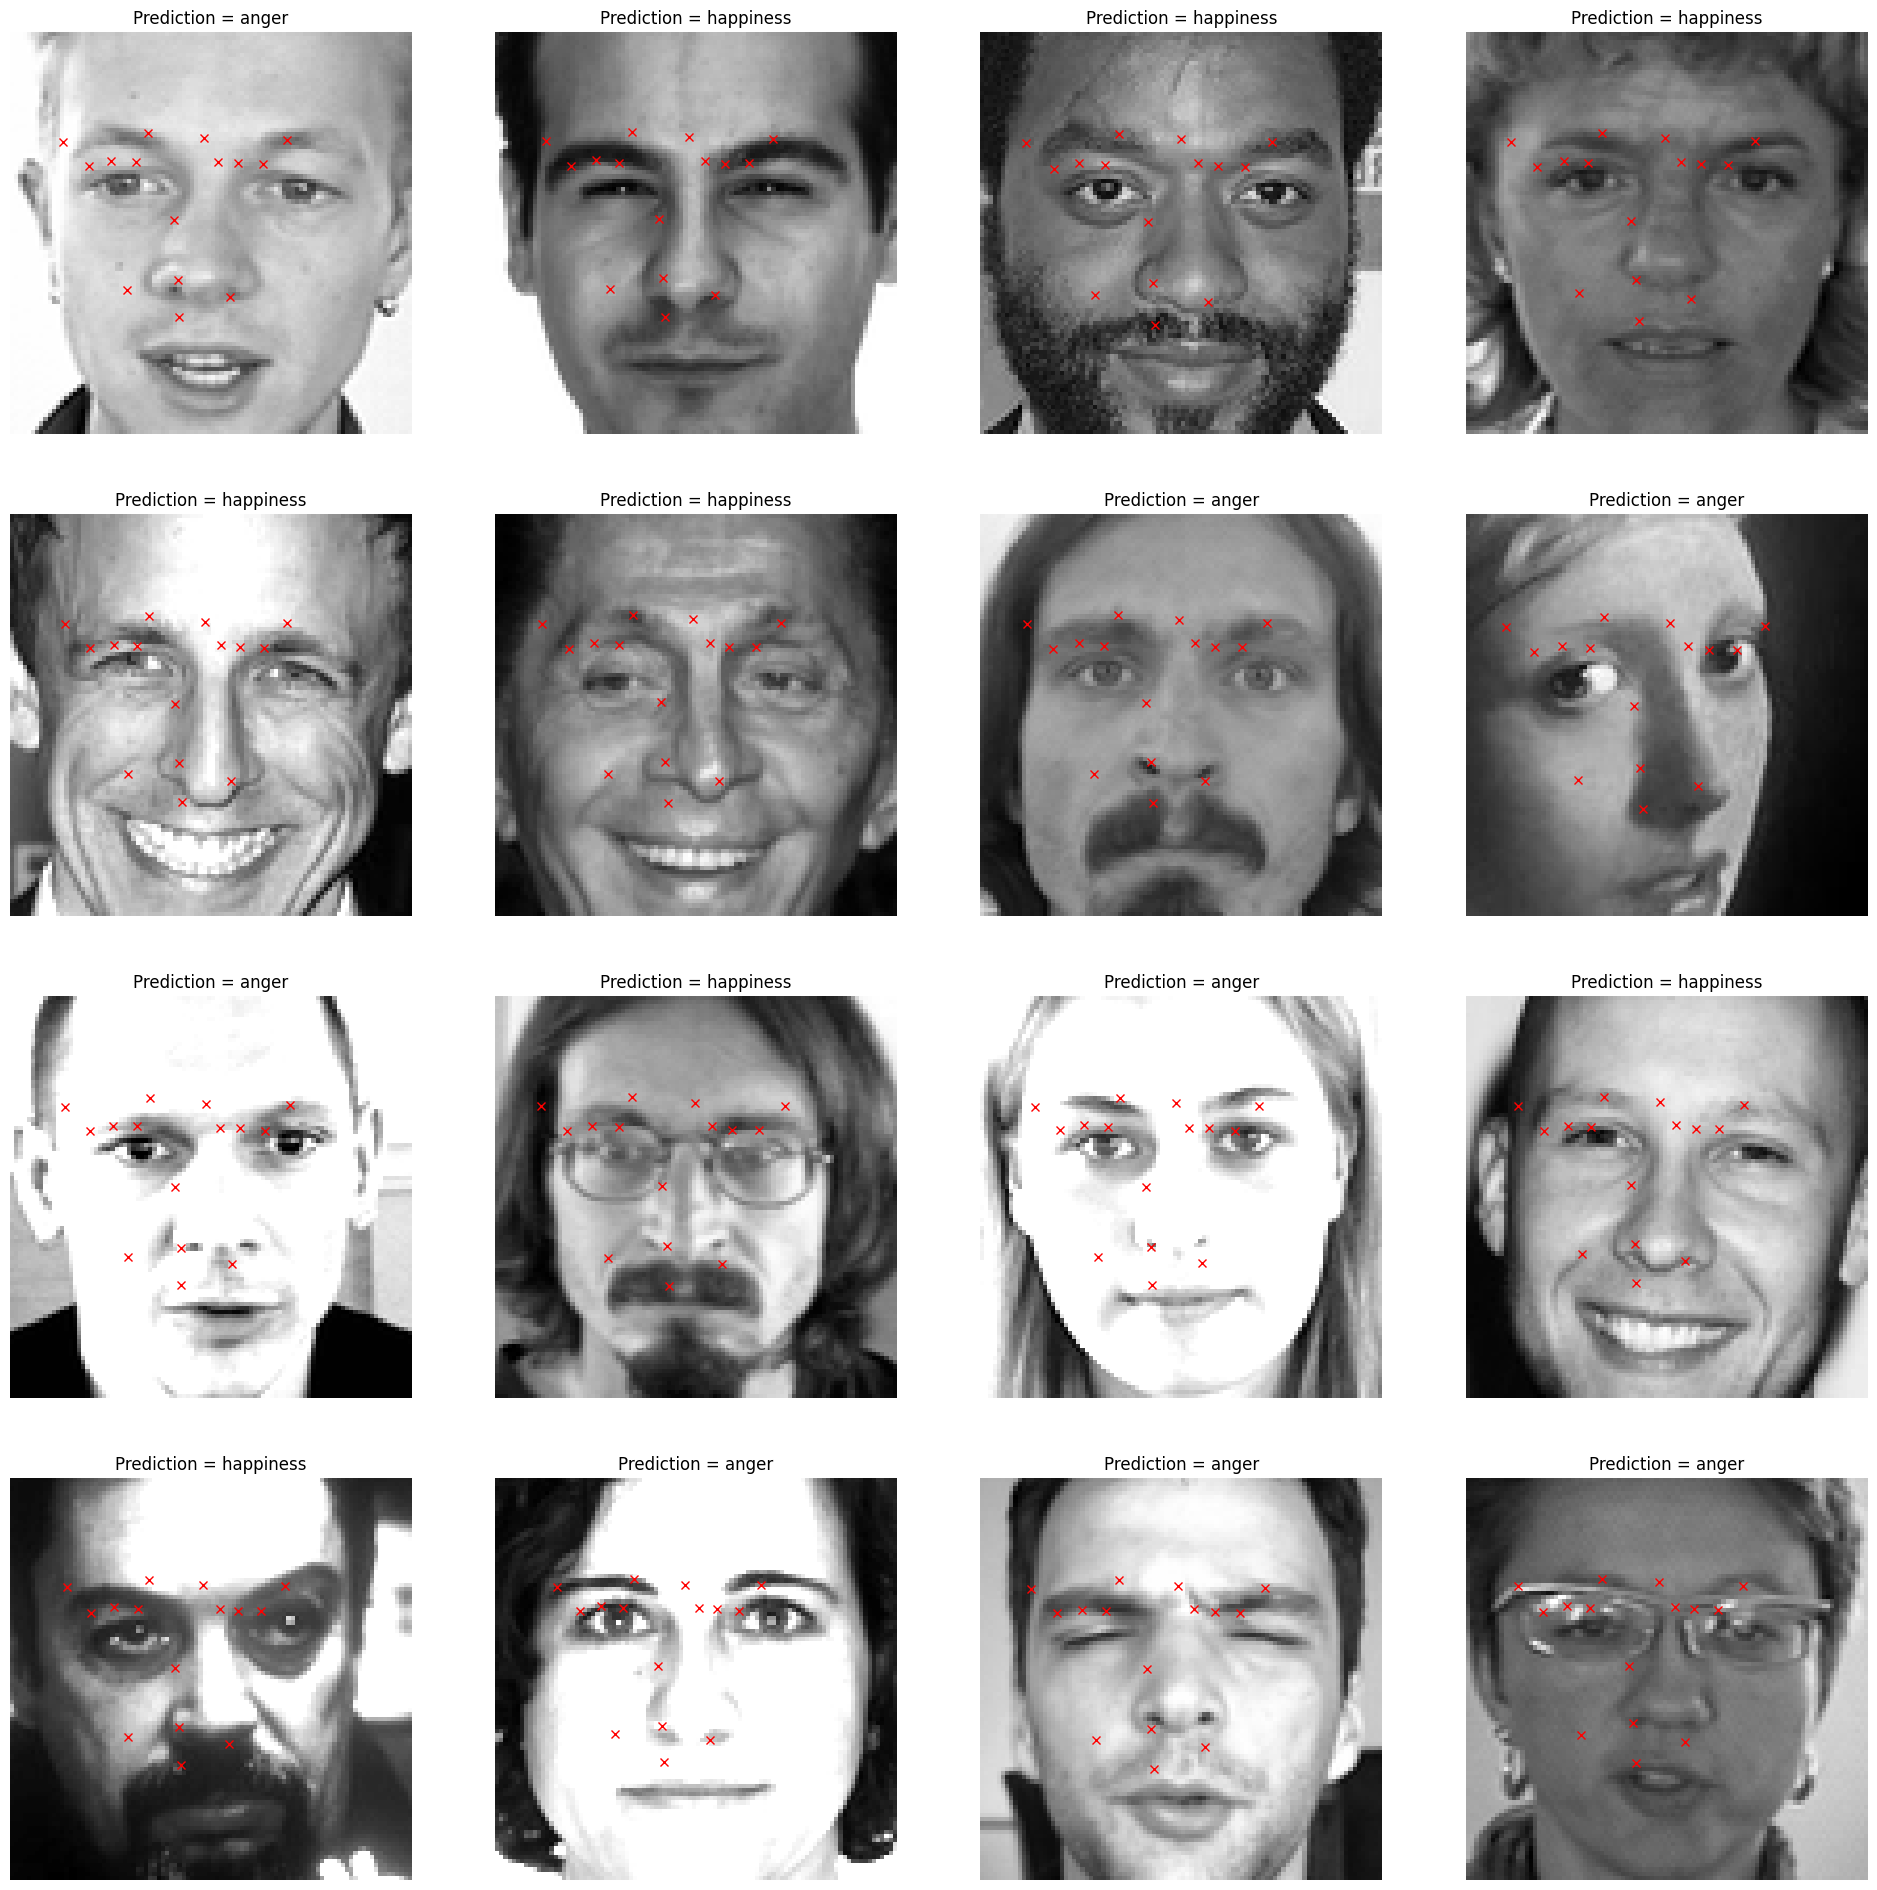

In [197]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
